In [1]:
%matplotlib inline
import warnings
import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [50]:
# Import data
test_features = pd.read_csv('test_features.csv')
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')

# assign to train, test, and submission
X_train = train_features.drop(columns='id')
X_test = test_features.drop(columns='id')
y_train = train_labels.drop(columns='id')
submission = test_features[['id']]

X_train.shape, X_test.shape, y_train.shape

((59400, 39), (14358, 39), (59400, 1))

In [4]:
def submission_csv(y_pred, file_name):
    """
    Function to create csv file to be submitted to Kaggle.com
    
    Parameters
    ----------
    y_pred: a 1-D array of model predictions
    file_name: name for new csv file as a string
    
    Returns
    -------
    A csv file in the current directory with a column for label id and predicted labels.
    """
    y_pred = y_pred.copy()
    submission['status_group'] = y_pred
    submission.to_csv(file_name, index=False)

In [5]:
# Example submission code
# submit predictions to kaggle
#!kaggle competitions submit -c ds3-predictive-modeling-challenge -f kaggle-submission-004.csv -m "Kitchen sink model with hyper-parameter

### Data Cleaning

In [6]:
numeric = X_train.select_dtypes(include='number').columns.tolist()
categorical = X_train.select_dtypes(exclude='number').columns.tolist()

print(numeric)
print('\n', categorical)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']

 ['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [64]:
def wrangle(X):
    # Create copy of dataframe to avoid copy warning
    X = X.copy()
    
    # Some features have missing data showing as 0 that need to be changed to nan
    X['gps_height'] = X['gps_height'].replace(0.0, np.nan)
    X['longitude'] = X['longitude'].replace(0.0, np.nan)
    X['latitude'] = X['latitude'].replace(0.0, np.nan)
    X['construction_year'] = X['construction_year'].replace(0.0, np.nan)
    X['population'] = X['population'].replace(0.0, np.nan)
    X['amount_tsh'] = X['amount_tsh'].replace(0.0, np.nan)
    
    # gps_height: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['gps_height'].fillna(X.groupby(['ward'])['gps_height'].transform('mean'), inplace=True)
    X['gps_height'].fillna(X.groupby(['district_code'])['gps_height'].transform('mean'), inplace=True)
    X['gps_height'].fillna(X.groupby(['region_code'])['gps_height'].transform('mean'), inplace=True)
    X['gps_height'].fillna(X['gps_height'].mean(), inplace=True)
    
    # longitude: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['longitude'].fillna(X.groupby(['ward'])['longitude'].transform('mean'), inplace=True)
    X['longitude'].fillna(X.groupby(['district_code'])['longitude'].transform('mean'), inplace=True)
    X['longitude'].fillna(X.groupby(['region_code'])['longitude'].transform('mean'), inplace=True)
    X['longitude'].fillna(X['longitude'].mean(), inplace=True)
    
    # latitude: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['latitude'].fillna(X.groupby(['ward'])['latitude'].transform('mean'), inplace=True)
    X['latitude'].fillna(X.groupby(['district_code'])['latitude'].transform('mean'), inplace=True)
    X['latitude'].fillna(X.groupby(['region_code'])['latitude'].transform('mean'), inplace=True)
    X['latitude'].fillna(X['latitude'].mean(), inplace=True)
    
    # population: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['population'].fillna(X.groupby(['ward'])['population'].transform('median'), inplace=True)
    X['population'].fillna(X.groupby(['district_code'])['population'].transform('median'), inplace=True)
    X['population'].fillna(X.groupby(['region_code'])['population'].transform('median'), inplace=True)
    X['population'].fillna(X['population'].median(), inplace=True)
    
    # population: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['amount_tsh'].fillna(X.groupby(['ward'])['amount_tsh'].transform('median'), inplace=True)
    X['amount_tsh'].fillna(X.groupby(['district_code'])['amount_tsh'].transform('median'), inplace=True)
    X['amount_tsh'].fillna(X.groupby(['region_code'])['amount_tsh'].transform('median'), inplace=True)
    X['amount_tsh'].fillna(X['amount_tsh'].median(), inplace=True)
    
    # construction_year: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['construction_year'].fillna(X.groupby(['ward'])['construction_year'].transform('median'), inplace=True)
    X['construction_year'].fillna(X.groupby(['district_code'])['construction_year'].transform('median'), inplace=True)
    X['construction_year'].fillna(X.groupby(['region_code'])['construction_year'].transform('median'), inplace=True)
    X['construction_year'].fillna(X['construction_year'].median(), inplace=True)
    
    # Convert date to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract datetime data
    X['year_recorded'] = X['date_recorded'].dt.year
    
    # Drop duplicate or unnecessary features
    X = X.drop(columns=['recorded_by', 'quantity_group', 'date_recorded', 'wpt_name', 'num_private', 'subvillage',
                       'region_code', 'district_code', 'management_group', 'extraction_type_group', 'extraction_type_class',
                       'scheme_name', 'payment', 'water_quality', 'source_type', 'source_class', 'waterpoint_type_group',
                       'ward', 'public_meeting', 'permit'])
    
    # Several categorical features have values showing as '0'
    # Replace '0' with nan
    categoricals = X.select_dtypes(exclude='number').columns.tolist()
    X[categoricals] = X[categoricals].replace('0', np.nan)
    
    # Convert to lowercase to collapse duplicates
    X['waterpoint_type'] = X['waterpoint_type'].str.lower()
    X['funder'] = X['funder'].str.lower()
    X['basin'] = X['basin'].str.lower()
    X['region'] = X['region'].str.lower()
    X['source'] = X['source'].str.lower()
    X['lga'] = X['lga'].str.lower()
    X['management'] = X['management'].str.lower()
    X['quantity'] = X['quantity'].str.lower()
    X['quality_group'] = X['quality_group'].str.lower()
    X['payment_type'] = X['payment_type'].str.lower()
    X['extraction_type'] = X['extraction_type'].str.lower()
    
    # Replace nan values with 'other'
    X["funder"].fillna("other", inplace=True)
    X["scheme_management"].fillna("other", inplace=True)
    X["installer"].fillna("other", inplace=True)
    
    X = X.replace(np.nan, 'other')
    
    return X

In [52]:
X_train_clean = wrangle(X_train)
X_test_clean = wrangle(X_test)

X_train_clean.shape, X_test_clean.shape

((59400, 20), (14358, 20))

### Feature engineering

In [63]:
def feature_eng(X):
    X = X.copy()
    
    # Engineered features from data exploration and cleaning notebook
    X['amount_tsh_above_1000'] = X['amount_tsh'] > 1000
    X['water_quality_good_and_seasonal'] = (X['quality_group'] == 'good') & (X['quantity'] == 'seasonal')
    X['water_quality_good_and_dry'] = (X['quality_group'] == 'good') & (X['quantity'] == 'dry')
    X['water_quality_good_and_insufficient'] = (X['quality_group'] == 'good') & (X['quantity'] == 'insufficient')
    X['water_quality_good_and_enough'] = (X['quality_group'] == 'good') & (X['quantity'] == 'enough')
    X['water_quality_good'] = X['quality_group'] == 'good'
    
    #Since some years show as 0, I'll have to manually clean up the new features
    X['age'] = 2019 - X['construction_year']
    X['years_since_inspection'] = 2019 - X['year_recorded']
    
    return X

In [54]:
X_train_eng = feature_eng(X_train_clean)
X_test_eng = feature_eng(X_test_clean)

X_train_eng.shape, X_test_eng.shape

((59400, 28), (14358, 28))

### Feature scaling and encoding

In [55]:
scaler = RobustScaler()
encoder = ce.OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train_eng)
X_test_encoded = encoder.transform(X_test_eng)
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [56]:
X_train_scaled.shape, X_test_scaled.shape

((59400, 28), (14358, 28))

### Fit data to a model

In [29]:
# Set parameters
param_dist = {
    'n_estimators': randint(100, 300),
    'max_features': randint(2, 30)
}

# Create randomized search
search = RandomizedSearchCV(
    estimator=RandomForestClassifier(max_depth=6, n_jobs=-1, random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=10,
    return_train_score=True,
    random_state=42
)

# fit the model
search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 37.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 44

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=6,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=-1, oob

In [30]:
search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=249,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [31]:
search.best_score_

0.7242760942760943

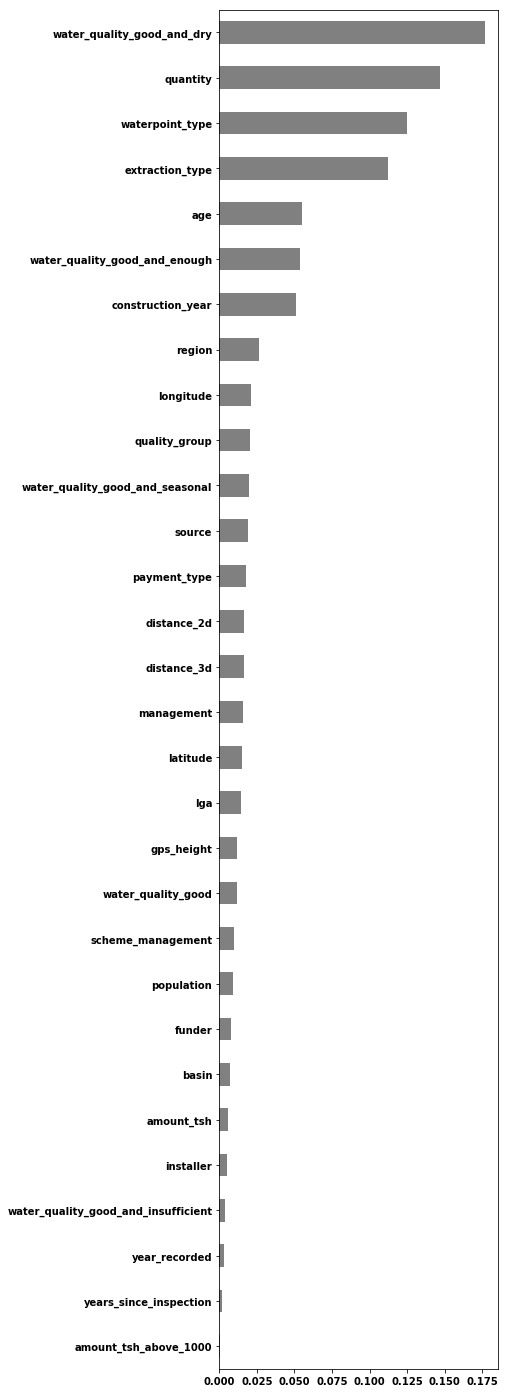

In [32]:
best = search.best_estimator_
n = len(X_train_encoded.columns)

importances = pd.Series(best.feature_importances_, X_train_encoded.columns)
top_n = importances.sort_values()[-n:]
plt.figure(figsize=(5, 25))
top_n.plot.barh(color='gray');

In [36]:
# Make predictions
y_pred = best.predict(X_test_scaled)

# Create kaggle submission csv
submission_csv(y_pred, 'kaggle-submission-006.csv')

C:\Users\theta\Anaconda3\envs\lambda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Run Model using max_depth=None

In [44]:
# Set parameters
param_dist = {
    'n_estimators': randint(50, 300),
    'max_features': randint(3, 30),
    'criterion': ['gini', 'entropy']
}

# Create randomized search
search = RandomizedSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=None),
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    n_jobs=-1,
    cv=3,
    verbose=10,
    return_train_score=True,
    random_state=42
)

# fit the model
search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 46.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 53.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 56.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=-1, 

In [46]:
search.best_score_

0.8029292929292929

In [48]:
best = search.best_estimator_

# Make predictions
y_pred = best.predict(X_test_scaled)

# Make submission csv file
submission_csv(y_pred, 'kaggle-submission-007.csv')

C:\Users\theta\Anaconda3\envs\lambda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [49]:
# Submit predictions to Kaggle
!kaggle competitions submit -c ds3-predictive-modeling-challenge -f kaggle-submission-007.csv -m "RFC cleaned and w/ engineered features"

Successfully submitted to DS3 Predictive Modeling Challenge



  0%|          | 0.00/277k [00:00<?, ?B/s]
  3%|2         | 8.00k/277k [00:00<00:09, 27.6kB/s]
 29%|##8       | 80.0k/277k [00:00<00:05, 38.7kB/s]
 38%|###7      | 104k/277k [00:00<00:03, 51.4kB/s] 
 46%|####6     | 128k/277k [00:00<00:02, 66.7kB/s]
100%|##########| 277k/277k [00:03<00:00, 94.3kB/s]


### I made some changes to the wrangle function and feature_eng function. Re-running best estimator model with updates

In [45]:
search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [57]:
from sklearn.model_selection import train_test_split

# Create train and validate sets
X_train2, X_val, y_train2, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

In [58]:
from sklearn.metrics import accuracy_score

# Set model params
model = RandomForestClassifier(criterion='entropy', max_features=4, n_estimators=251, n_jobs=-1, random_state=42)

# Fit the model
model.fit(X_train2, y_train2)

# Make Predictions
y_pred = model.predict(X_val)

# Check score
score = accuracy_score(y_val, y_pred)
score

0.8053872053872054

In [60]:
# Make predictions for Kaggle
y_pred = model.predict(X_test_scaled)

# Make csv file
submission_csv(y_pred, 'kaggle-submission-008.csv')

C:\Users\theta\Anaconda3\envs\lambda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [65]:
# Submit to Kaggle
!kaggle competitions submit -c ds3-predictive-modeling-challenge -f kaggle-submission-008.csv -m "RFC best_estimator_ with tweaks to cleaning and feature engineering functions"

Successfully submitted to DS3 Predictive Modeling Challenge



  0%|          | 0.00/279k [00:00<?, ?B/s]
  3%|2         | 8.00k/279k [00:00<00:09, 28.0kB/s]
 29%|##8       | 80.0k/279k [00:00<00:05, 39.3kB/s]
 37%|###7      | 104k/279k [00:00<00:03, 52.3kB/s] 
 72%|#######1  | 200k/279k [00:00<00:01, 73.0kB/s]
100%|##########| 279k/279k [00:02<00:00, 120kB/s] 


### An attempt at stacking

In [62]:
# Filenames of your submissions you want to ensemble
files = ['kaggle-submission-001.csv', 'kaggle-submission-002.csv', 'kaggle-submission-003.csv', 'kaggle-submission-004.csv', 
         'kaggle-submission-005.csv', 'kaggle-submission-006.csv', 'kaggle-submission-007.csv', 'kaggle-submission-008.csv']

submissions = (pd.read_csv(file)[['status_group']] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)

In [66]:
# Submit to Kaggle
!kaggle competitions submit -c ds3-predictive-modeling-challenge -f my-ultimate-ensemble-submission.csv -m "1st attempt at stacking"

Successfully submitted to DS3 Predictive Modeling Challenge



  0%|          | 0.00/263k [00:00<?, ?B/s]
  3%|3         | 8.00k/263k [00:00<00:08, 31.6kB/s]
 30%|###       | 80.0k/263k [00:00<00:04, 44.4kB/s]
 40%|###9      | 104k/263k [00:00<00:02, 58.1kB/s] 
 70%|######9   | 184k/263k [00:00<00:01, 80.5kB/s]
100%|##########| 263k/263k [00:02<00:00, 104kB/s] 
